# 导入需要的包
matplotlib,numpy,touch,PIL

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
from torch import nn,optim
from torch.autograd import Variable
import torch.nn.functional as F

In [3]:
import torchvision
from torchvision import datasets,transforms,models

In [4]:
from PIL import Image

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
# Tell the machine what folder contains the image data
data_dir = './Data'


# Read the data, crop and resize the images, split data into two groups: test and train
def load_split_train_test(data_dir, valid_size=.2):

    # Transform the images to train the model
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
    ])

    # Transform the images to test the model
    test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
    ])

    # Create two variables for the folders with the training and testing images
    train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=test_transforms)

    # Get the number of images in the training folder
    num_train = len(train_data)

    # Create a list of numbers from 0 to the number of training images - 1
    # Example: For 10 images, the variable is the list [0,1,2,3,4,5,6,7,8,9]
    indices = list(range(num_train))

    # If valid_size is .2, find the index of the image that represents 20% of the data
    # If there are 10 images, a split would result in 2
    # split = int(np.floor(.2 * 10)) -> int(np.floor(2)) -> int(2) -> 2
    split = int(np.floor(valid_size * num_train))

    # Randomly shuffle the indices
    # For 10 images, an example would be that indices is now the list [2,5,4,6,7,1,3,0,9,8]
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler

    # With the indices randomly shuffled,
    # grab the first 20% of the shuffled indices, and store them in the training index list
    # grab the remainder of the shuffled indices, and store them in the testing index list
    # Given our example so far, this would result is:
    # train_idx is the list [1,5]
    # test_idx is the list [4,6,7,1,3,0,9,8]
    train_idx, test_idx = indices[split:], indices[:split]

    # Create samplers to randomly grab items from the training and testing indices lists
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Create loaders to load 16 images from the train and test data folders
    # Images are chosen based on the shuffled index lists and by using the samplers
    trainloader = torch.utils.data.DataLoader(train_data,
                                              sampler=train_sampler,
                                              batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data,
                                             sampler=test_sampler,
                                             batch_size=16)

    # Return the loaders so you can grab images randomly from the training and testing data folders
    return trainloader, testloader


# Using the function that shuffles images,
# create a trainloader to load 20% of the images
# create a testloader to load 80% of the images
trainloader, testloader = load_split_train_test(data_dir, .2)

# Print the type of rocks that are included in the trainloader
print(trainloader.dataset.classes)

['Basalt', 'Highland']


In [7]:
# Transform an image into pixels and resize it
test_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
])


# Randomly select a set of images by using a similar approach as the load_split_train_test function
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    # Create an iterator to iterate over the shuffled images in the test image dataset
    dataiter = iter(loader)

    # Get and return the images and labels from the iterator
    images, labels = dataiter.next()
    return images, labels

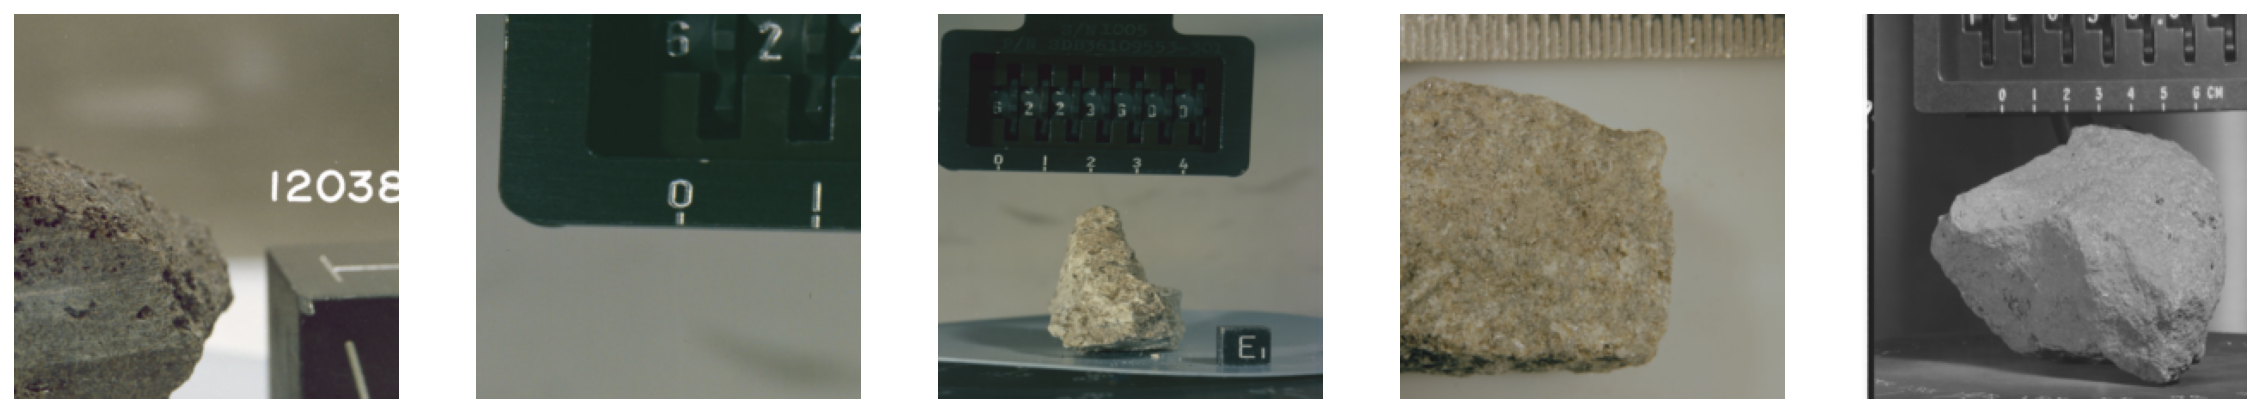

In [8]:
# Show five images - you can change this number
images, labels = get_random_images(5)

# Convert the array of pixels to an image
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))

# Get a list of all classes in the training data
classes = trainloader.dataset.classes

# Draw the images in a plot to display in the notebook
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii + 1)
    plt.axis('off')
    plt.imshow(image)

# Display all of the images
plt.show()

In [ ]:
# Determine if you're using a CPU or a GPU device to build the deep learning network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True,progress=True)

In [ ]:
# Build all the neurons
for param in model.parameters():
    param.requires_grad = False

# Wire the neurons together to create the neural network
model.fc = nn.Sequential(nn.Linear(2048, 512), nn.ReLU(), nn.Dropout(0.2),
                         nn.Linear(512, 6), nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# Add the neural network to the device
model.to(device)

print('done')

In [ ]:
# Set the initial number of iterations to search for associations
epochs = 10
print_every = 5

# Initialize the loss variables
running_loss = 0
train_losses, test_losses = [], []

# Track the current training step, start at 0
steps = 0

# Search for associations in the features
for epoch in range(epochs):

    # Count each epoch
    epoch += 1

    # Load in all of the image inputs and labels from the TRAIN loader
    for inputs, labels in trainloader:

        # Count each training step
        steps += 1
        print('Training step ', steps)

        # Load the inputs and labels to the already selected device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero out gradients to avoid accumulations of gradiants across training iterations
        optimizer.zero_grad()

        # Pass the images through the model, return the log probabilities of each label
        logps = model.forward(inputs)

        # Run the log probabilities through the criterion to get the output graph
        loss = criterion(logps, labels)

        # Use the loss graph to compute gradients
        loss.backward()

        # Update the parameters based on the current gradient
        optimizer.step()

        # Add the actual loss number to the running loss total
        running_loss += loss.item()

        # Every 5 steps, evaluate the model
        if steps % print_every == 0:

            # Initialize loss and accuracy
            test_loss = 0
            accuracy = 0

            # Start the model evaluation
            model.eval()

            # Refine the accuracy of the prediction without updating the gradients
            with torch.no_grad():

                # Load in all of the image inputs and labels from the TEST loader
                for inputs, labels in testloader:

                    # Load the inputs and labels to the already selected device
                    inputs, labels = inputs.to(device), labels.to(device)

                    # Pass the images through the model, return the log probabilities of each label
                    logps = model.forward(inputs)

                    # Run the log probabilities through the criterion to get the output graph
                    batch_loss = criterion(logps, labels)

                    # Add the actual loss number to the running loss total for the test batch
                    test_loss += batch_loss.item()

                    # Return a new tensor with the true probabilities
                    ps = torch.exp(logps)

                    # Return the largest probability and class of the new tensor along a given dimension
                    top_p, top_class = ps.topk(1, dim=1)

                    # Reshape the tensor to match the same shape as the top class
                    equals = top_class == labels.view(*top_class.shape)

                    # Compute the accuracy and add it to the running accuracy count for the test batch
                    accuracy += torch.mean(equals.type(
                        torch.FloatTensor)).item()

            # Append the training and testing losses
            train_losses.append(running_loss / len(trainloader))
            test_losses.append(test_loss / len(testloader))

            # Display the accuracy of the prediction with 3 digits in the fractional part of the decimal
            print(f"\n     Epoch {epoch}/{epochs}: "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}\n")

            # Train the model
            running_loss = 0
            model.train()

            # After 5 training steps, start the next epoch
            # Break here in case the trainloader has remaining data
            break


上面这个Jupyter模块是用来训练模型的主要部分

In [ ]:
print(accuracy / len(testloader))


In [ ]:
torch.save(model, 'aerialmodel.pth')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('aerialmodel.pth')


In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
# Get five random images and display them in a figure with their labels
to_pil = transforms.ToPILImage()
images, labels = get_random_images(10)
fig = plt.figure(figsize=(20, 10))

# Load all of the classes from the training loader
classes = trainloader.dataset.classes

# Loop through the 5 randomly selected images
for ii in range(len(images)):

    # Predict the class of each image
    image = to_pil(images[ii])
    index = predict_image(image)

    # Add the class to the plot graph to display beneath the image
    sub = fig.add_subplot(1, len(images), ii + 1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)

# Reshow the plot with the predicted labels beneath the images
plt.show()